# 효율적 경계선 Part II


이번 시간은 수익률 데이터를 로드하고 기대 수익률 벡터와 공분산 행렬을 생성하는 것으로 시작을 해보겠습니다.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import port_opt_toolkit as potk

ind = potk.get_ind_returns()
er = potk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


우선 첫 번째로, 가중치가 있다고 가정을 하고 그 가중치와 수익률 및 공분산 행렬을 사용하여 포트폴리오 전체의 수익률과 변동성을 계산해 보겠습니다.

포트폴리오의 수익률을 계산하는 것은 매우 쉽습니다. 우리는 이 함수를 도구상자 모듈에 추가하겠습니다.

```python

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

```

포트폴리오의 변동성 또한 다음과 같이 행렬을 사용하여 쉽게 구현이 가능합니다.

```python
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5
```

In [3]:
l = ["Food", "Beer", "Smoke", "Coal"]

In [4]:
er[l]

Food     0.116799
Beer     0.141100
Smoke    0.108223
Coal     0.414689
dtype: float64

In [5]:
cov.loc[l,l]

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002062,0.000027
Beer,0.002379,0.005265,0.001357,0.001728
Smoke,0.002062,0.001357,0.008365,-0.000726
Coal,0.000027,0.001728,-0.000726,0.018641


In [6]:
import pandas as pd
import numpy as np
ew = np.repeat(0.25, 4)
potk.portfolio_return(ew, er[l])

0.19520262766118368

In [7]:
potk.portfolio_vol(ew, cov.loc[l,l])

0.05507465182031142

# 2가지 자산 케이스

2개의 자산의 경우 두 번째 자산의 가중치는 1에서 첫 번째 자산의 가중치를 뺀 값이기 때문에 문제가 다소 단순화됩니다.

그렇기 때문에 우선은 간단한 2가지 자산 케이스에 대해 효율적 경계선을 그리는 함수를 작성해 보겠습니다.

튜플들의 리스트를 사용해 가중치 시퀀스를 생성합니다. 파이썬은 `for`를 사용하여 반복문을 생성하는 대신 리스트 컴프리헨션(**list comprehension**)이라는 보다 효율적인 방법이 있습니다. 우리는 이를 활용해 우리가 원하는 리스트를 쉽게 생성할 수 있습니다.

In [9]:
import numpy as np

n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]

In [10]:
type(weights)

list

In [11]:
len(weights)

20

In [12]:
weights[0]

array([0., 1.])

In [13]:
weights[4]

array([0.21052632, 0.78947368])

In [14]:
weights[19]

array([1., 0.])

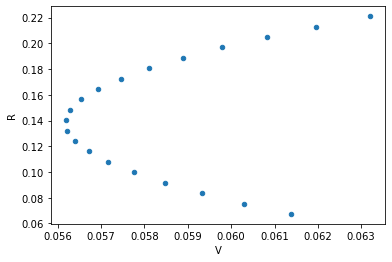

In [15]:
l = ["Games", "Fin"]
rets = [potk.portfolio_return(w, er[l]) for w in weights]
vols = [potk.portfolio_vol(w, cov.loc[l,l]) for w in weights]
ef = pd.DataFrame({"R": rets, "V": vols})
ef.plot.scatter(x="V", y="R")

아래의 함수는 효율적 경계선을 그리기 위한 함수입니다.

```python
def plot_ef2(n_points, er, cov):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] != 2 or er.shape[0] != 2:
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-")
```

판다스를 활용한 시각화 방법에 대한 보다 자세한 내용은 [여기](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)를 참고하시기 바랍니다.

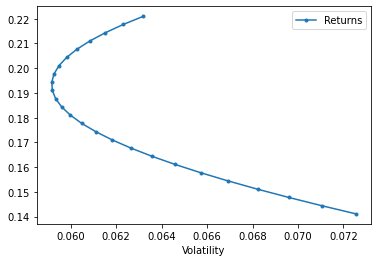

In [16]:
l = ["Fin", "Beer"]
potk.plot_ef2(25, er[l].values, cov.loc[l,l])